In [4]:
import json
import itertools
import numpy as np
import pandas as pd

import rule_application as ra
from grapher import Grapher
from temporal_walk import Temporal_Walk
from rule_learning import Rule_Learner, verbalize_rule, rules_statistics
from score_functions import score_12
from heuristic_walk import Heuristic_Walk
from heuristic_walk2 import Heuristic_Walk2
from temporal_walk_improved import TemporalWalkImproved

In [5]:
dataset = "icews14"
rules_file = "241123183324_r[1,2,3]_n200_exp_s12_rules.json"
dir_path = dataset + "/"

In [6]:
data = Grapher("../data/" + dir_path)
print("Shapes: ", np.shape(data.train_idx), np.shape(data.valid_idx), np.shape(data.test_idx))
print(data.train_idx[:5])

Grapher initialized.
Shapes:  (127370, 4) (27646, 4) (26444, 4)
[[ 146  178 2665    0]
 [ 265  156 1183    0]
 [ 382  127 2100    0]
 [ 467  224 1176    0]
 [ 467  229 6495    0]]


In [7]:
rules_dict = json.load(open("../output/" + dir_path + rules_file))
rules_dict = {int(k):v for k,v in rules_dict.items()}
rules_statistics(rules_dict)

Number of relations with rules:  427
Total number of rules:  26881
Number of rules by length:  [(1, 7847), (2, 7328), (3, 11706)]


In [8]:
temporal_walk = Temporal_Walk(data.train_idx, data.inv_relation_id, transition_distr="exp")
rl1 = Rule_Learner(temporal_walk.edges, data.id2relation, data.inv_relation_id, dataset)

In [9]:
heuristic_walk = Heuristic_Walk(data.train_idx, data.inv_relation_id, transition_distr="exp")  
rl2 = Rule_Learner(heuristic_walk.edges, data.id2relation, data.inv_relation_id, dataset)

#### Rule Learning

In [9]:
selected_relations = list(rules_dict.keys())[:100]
print(selected_relations)  

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107]


In [22]:
from tqdm import tqdm

def collect_data(walk_method, rl, num_relations=100, length=3):
    confidences = []
    rule_supports = []
    
    
    for rel_idx in tqdm(list(rules_dict.keys())[:num_relations], desc='Collecting data'):
        rl.rules_dict = dict()

        walk_successful = False
        max_attempts = 1000  
        attempts = 0  
        while not walk_successful and attempts < max_attempts:
            walk_successful, walk = walk_method.sample_walk(length + 1, rel_idx)
            attempts += 1  
        if not walk_successful:
            print(f"Failed to find a successful walk for relation index {rel_idx} after {max_attempts} attempts.")
            confidences.append(None)
            rule_supports.append(None)
            continue  
        
        
        rl.create_rule(walk)
        try:
            rule = rl.rules_dict[rel_idx][0]
            confidences.append(rule['conf'])
            rule_supports.append(rule['rule_supp'])
        except KeyError:
            confidences.append(None)
            rule_supports.append(None)

    return confidences, rule_supports


confidences_random, supports_random = collect_data(temporal_walk, rl1)

confidences_heuristic, supports_heuristic = collect_data(heuristic_walk, rl2)


def calculate_average(data):
    return sum(x for x in data if x is not None) / sum(1 for x in data if x is not None)


average_confidence_random = calculate_average(confidences_random)
print("Average Confidence Random Walk: ", average_confidence_random)

average_confidence_heuristic = calculate_average(confidences_heuristic)
print("Average Confidence Heuristic Walk (Edge Rarity): ", average_confidence_heuristic)


average_support_random = calculate_average(supports_random)
print("Average Support Random Walk: ", average_support_random)

average_support_heuristic = calculate_average(supports_heuristic)
print("Average Support Heuristic Walk (Edge Rarity): ", average_support_heuristic)


selected_relations = list(rules_dict.keys())[:100]

Average Confidence Random Walk:  0.20969777777777776
Average Confidence Heuristic Walk (Edge Rarity):  0.5617877118644069
Average Support Random Walk:  5.407407407407407
Average Support Heuristic Walk (Edge Rarity):  4.237288135593221


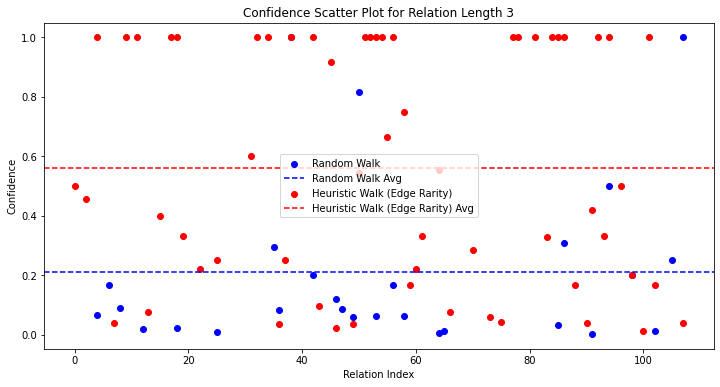

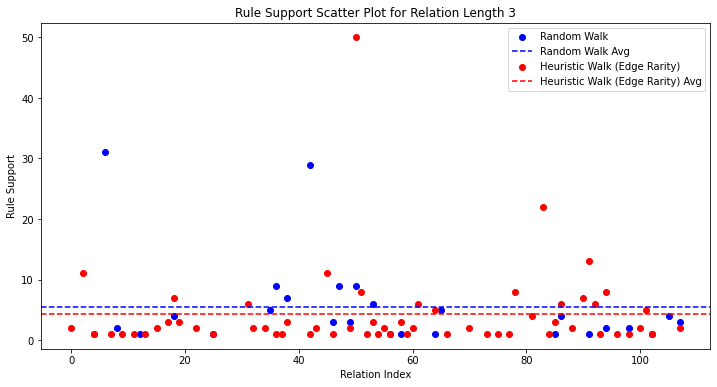

In [23]:
import matplotlib.pyplot as plt
import os

desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')

def plot_scatter_data_with_avg(title, x_label, y_label, data_x, data_y, labels, colors, averages, save_path):
    plt.figure(figsize=(12, 6))
    for x, y, label, color, avg in zip(data_x, data_y, labels, colors, averages):
        plt.scatter(x, y, label=label, color=color)
        plt.axhline(y=avg, color=color, linestyle='--', label=f'{label} Avg')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.savefig(save_path)  
    plt.show()
    
    


data_y_confidence = [confidences_random, confidences_heuristic]
averages_confidence = [average_confidence_random, average_confidence_heuristic]
conf_plot_path = os.path.join(desktop_path, 'confidence_scatter_plot.png')
plot_scatter_data_with_avg('Confidence Scatter Plot for Relation Length 3', 'Relation Index', 'Confidence', [selected_relations] * 2, data_y_confidence, ['Random Walk', 'Heuristic Walk (Edge Rarity)'], ['blue', 'red'], averages_confidence, conf_plot_path)


data_y_support = [supports_random, supports_heuristic]
averages_support = [average_support_random, average_support_heuristic]
support_plot_path = os.path.join(desktop_path, 'rule_support_scatter_plot.png')
plot_scatter_data_with_avg('Rule Support Scatter Plot for Relation Length 3', 'Relation Index', 'Rule Support', [selected_relations] * 2, data_y_support, ['Random Walk', 'Heuristic Walk (Edge Rarity)'], ['blue', 'red'], averages_support, support_plot_path)
